Goal: create a model that predicts severity of a collision, based on the features of the collision

Create a balanced training set of data:
- repeat the samples in the smallest class --> repeat the observations from the smallest (just do it with the training set) -- to rebalance (maybe add in cross validation)
- accuracy 
    -- how much better than the naive baselines (predict all one class)
    -- print confusion matrix (to visuzliae imbalanced problems)



In [9]:
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import RandomizedLasso
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


1) Load data  
    - 2014 attendant, vehicle, and casualty datasets
    - Description of data: https://drive.google.com/drive/u/0/folders/1afX9SJzqmO6rQG6FDhpMlzOfoy_NwI7Q
    - Merge on AREFNO
2) Train, Test split  
3) Hyper Paramter tuning for Random Forest Classifier  
3) Feature Importance  
4) Next: Visualize a decision tree  

** * Load Data * **

In [2]:
df_att = pd.read_csv('./data/2014-gla-data-extract-attendant.csv')
df_cas = pd.read_csv('./data/2014-gla-data-extract-casualty.csv')
df_veh = pd.read_csv('./data/2014-gla-data-extract-vehicle.csv')

df_crash = pd.merge(df_att, df_cas, on='AREFNO', how='inner')

df_crash = pd.merge(df_crash, df_veh, on='AREFNO', how='inner')

df_crash.Time = [int(x.strip("'")) for x in df_crash.Time]

df_crash['Accident Severity'].value_counts()

3 Slight     52331
2 Serious     3838
1 Fatal        237
Name: Accident Severity, dtype: int64

***2) Train, Test split  ***

- repeat the samples in the smallest class --> repeat the observations from the smallest (just do it with the training set) -- to rebalance (maybe add in cross validation)
- accuracy 
    -- how much better than the naive baselines (predict all one class)
    -- print confusion matrix (to visuzliae imbalanced problems)

In [3]:
# Select X and y data

y = df_crash['Accident Severity']

X = df_crash[[
    'Day', 'Time', 'Highway',
       'Road Class 1', 'Road Type', 'Speed Limit',
       'Junction Detail', 'Junction Control', 'Road Class 2', 
       'Ped. Crossing Decoded', 'Light Conditions (Banded)', 'Weather',
       'Road Surface', 'Special Conditions', 'C/W Hazard', 'Casualty Class',
       'No. of Casualties', 'Ped. Location',
       'Ped. Movement', 'Mode of Travel', 'Vehicle Type',
        'Vehicle Type (Banded)',
       'Vehicle Manoeuvres', 'Vehicle Skidding', 'Restricted Lane',
       'Junction Location', 'Object in C/W', 'Veh. Leaving C/W',
       'Veh. off C/W','VJNYPURP DECODED']]

print ('X shape: ', X.shape)
print ('y shape: ', y.shape)

X=pd.get_dummies(X)
print ('X shape: ', X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0, stratify=y)

print ('\n shape')
print ('X: train, test', X_train.shape, X_test.shape, '\n')
print ('y: train, test', y_train.shape, y_test.shape)

X shape:  (56406, 30)
y shape:  (56406,)
X shape:  (56406, 217)

 shape
X: train, test (33843, 217) (22563, 217) 

y: train, test (33843,) (22563,)


*** 3) Balancing samples in training set ***

Code taken from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

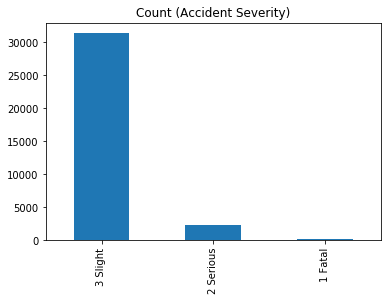

In [4]:
df_train = X.loc[X_train.index]
df_train['Accident Severity'] = y[y_train.index]
df_train['Accident Severity'].value_counts().plot(kind='bar', title='Count (Accident Severity)');

In [5]:
# Class count
count_class_3, count_class_2, count_class_1 = df_train['Accident Severity'].value_counts()

# Divide by class
df_class_3 = df_train[df_train['Accident Severity'] == '3 Slight']
df_class_2 = df_train[df_train['Accident Severity'] == '2 Serious']
df_class_1 = df_train[df_train['Accident Severity'] == '1 Fatal']

Random over-sampling:
2 Serious    31398
3 Slight     31398
1 Fatal      31398
Name: Accident Severity, dtype: int64


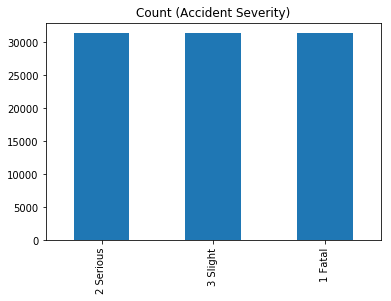

In [7]:
df_class_1_over = df_class_1.sample(count_class_3, replace=True) #take the number of fatal accidents as slight
df_class_2_over = df_class_2.sample(count_class_3, replace=True)
df_train_over = pd.concat([df_class_3, df_class_2_over, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_train_over['Accident Severity'].value_counts())

df_train_over['Accident Severity'].value_counts().plot(kind='bar', title='Count (Accident Severity)');

In [9]:
# split df_train into X and y

y_train_over = df_train_over['Accident Severity']

X_train_over = df_train_over.drop(['Accident Severity'], axis=1)


print ('X shape: ', X_train_over.shape)
print ('y shape: ', y_train_over.shape)



X shape:  (94194, 217)
y shape:  (94194,)


*** Random Forest Modeling ***

In [28]:
#Naive predictor accuracy

len(y_test[y_test == '3 Slight'])/ len(y_test)*100.00


92.77578336214157

In [10]:
rf = RandomForestClassifier(n_jobs=-1, random_state=0,n_estimators=100)

rf=rf.fit(X_train_over,y_train_over)#run predictor with each parameter using training data
pred=rf.predict(X_test)

print ('Accuracy: %.2f' % ((len(y_test[pred == y_test])/len(y_test))*100))

Accuracy: 93.51


Confusion matrix:
 [[   29     1    65]
 [    1   301  1233]
 [    3   161 20769]]


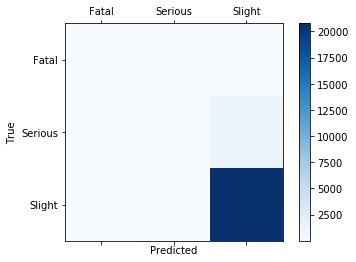

In [11]:
# COnfusion matrix code

y_pred = rf.predict(X_test)

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=['1 Fatal', '2 Serious', '3 Slight'])
print('Confusion matrix:\n', conf_mat)

labels = ['Fatal', 'Serious', 'Slight']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
count_cls_3, count_cls_2, count_cls_1 =y_test.value_counts()

conf_mat_pct = (np.array(conf_mat.T / np.array([count_cls_1, count_cls_2, count_cls_3])).T)*100.00

Confusion matrix, (%):
 [[  3.05263158e+01   1.05263158e+00   6.84210526e+01]
 [  6.51465798e-02   1.96091205e+01   8.03257329e+01]
 [  1.43314384e-02   7.69120527e-01   9.92165480e+01]]


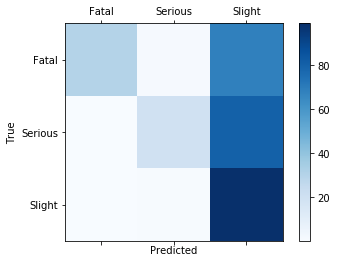

In [13]:
print('Confusion matrix, (%):\n', conf_mat_pct)

labels = ['Fatal', 'Serious', 'Slight']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_pct, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
param_grid ={'max_leaf_nodes':np.arange(2,30,3)} #choose a grid of parameters



rf = RandomForestClassifier(n_jobs=-1, n_estimators= 100)#don't specifcy n_est in the intialization
gr=GridSearchCV(rf,param_grid=param_grid)#pass in predictor, and gridded parameters
rs=gr.fit(X_train_over,y_train_over)#run predictor with each parameter using training data

print (rs.best_params_) 

{'max_leaf_nodes': 29}


In [146]:
param_grid ={'max_depth':[None, 2, 5, 10, 20]} #choose a grid of parameters



rf = RandomForestClassifier(n_jobs=-1, n_estimators= 100, max_leaf_nodes= 29)#don't specifcy n_est in the intialization
gr=GridSearchCV(rf,param_grid=param_grid)#pass in predictor, and gridded parameters
rs=gr.fit(X_train_over,y_train_over)#run predictor with each parameter using training data

print (rs.best_params_) 

{'max_depth': 10}


In [23]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0,n_estimators=100, max_leaf_nodes= 29, max_depth=10)

rf=rf.fit(X_train_over,y_train_over)#run predictor with each parameter using training data
pred=rf.predict(X_test)

print ('Accuracy: %.2f' % ((len(y_test[pred == y_test])/len(y_test))*100))

Accuracy: 57.51


In [24]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0,n_estimators=100, max_depth=10)

rf=rf.fit(X_train_over,y_train_over)#run predictor with each parameter using training data
pred=rf.predict(X_test)

print ('Accuracy: %.2f' % ((len(y_test[pred == y_test])/len(y_test))*100))

Accuracy: 67.90


In [25]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0,n_estimators=100)

rf=rf.fit(X_train_over,y_train_over)#run predictor with each parameter using training data
pred=rf.predict(X_test)

print ('Accuracy: %.2f' % ((len(y_test[pred == y_test])/len(y_test))*100))

Accuracy: 93.51


***4) Feature Importance  ***

Random Forest Feature ranking:          0                                                1
0   0.1194                                             Time
1   0.0189          Vehicle Manoeuvres_18 Going Ahead Other
2   0.0184                             Mode of Travel_4 Car
3   0.0167                                    Day_Friday   
4   0.0163                                   Road Class 1_A
5   0.0162             Light Conditions (Banded)_1 Daylight
6   0.0158  Ped. Crossing Decoded_0 No Xing Facility In 50m
7   0.0158                      Junction Location_8 Jct Mid
8   0.0157                                    Day_Thursday 
9   0.0155                 Light Conditions (Banded)_2 Dark
10  0.0153                                    Day_Monday   
11  0.0147                 Veh. Leaving C/W_0 Did Not Leave
12  0.0147                                    Day_Saturday 
13  0.0146                                   Highway_1 TLRN
14  0.0145                                    Highway_3 Bor


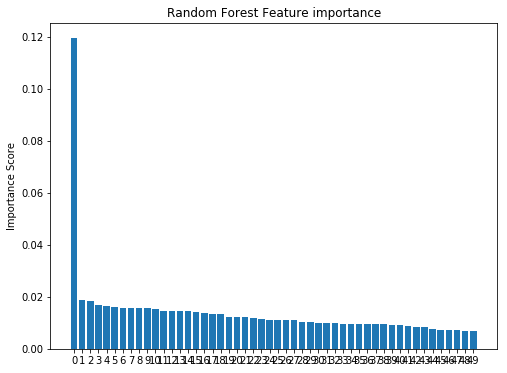

In [33]:
names = X_train_over.columns
feat_sort = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
feat_num=50

pl.figure(figsize=(8,6))
pl.title("Random Forest Feature importance")
pl.bar(np.arange(feat_num), pd.DataFrame(feat_sort)[0][:feat_num], align='center')
pl.xticks(np.arange(feat_num))
pl.ylabel('Importance Score')

print("Random Forest Feature ranking:", pd.DataFrame(feat_sort)[:15])

*** Redo Sampling with under sampling of Slight samples ***

Random over-sampling:
1 Fatal      2303
2 Serious    2303
3 Slight     2303
Name: Accident Severity, dtype: int64
X shape:  (6909, 217)
y shape:  (6909,)


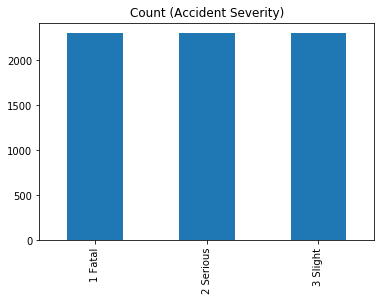

In [6]:
df_class_1_over = df_class_1.sample(count_class_2, replace=True) #take the number of fatal accidents as slight
df_class_3_under = df_class_3.sample(count_class_2, replace=True)
df_train_over_under = pd.concat([df_class_3_under, df_class_2, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_train_over_under['Accident Severity'].value_counts())

df_train_over_under['Accident Severity'].value_counts().plot(kind='bar', title='Count (Accident Severity)');

# split df_train into X and y

y_train_over_under = df_train_over_under['Accident Severity']

X_train_over_under = df_train_over_under.drop(['Accident Severity'], axis=1)


print ('X shape: ', X_train_over_under.shape)
print ('y shape: ', y_train_over_under.shape)


In [7]:
rf = RandomForestClassifier(n_jobs=-1, random_state=0,n_estimators=100)

rf=rf.fit(X_train_over_under,y_train_over_under)#run predictor with each parameter using training data
pred=rf.predict(X_test)

print ('Accuracy: %.2f' % ((len(y_test[pred == y_test])/len(y_test))*100))

Accuracy: 63.23


Confusion matrix:
 [[   36    44    15]
 [   11  1181   343]
 [   97  7787 13049]]


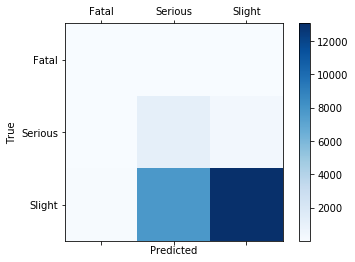

In [10]:
# COnfusion matrix code 

y_pred = rf.predict(X_test)

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=['1 Fatal', '2 Serious', '3 Slight'])
print('Confusion matrix:\n', conf_mat)

labels = ['Fatal', 'Serious', 'Slight']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [11]:
count_cls_3, count_cls_2, count_cls_1 =y_test.value_counts()

conf_mat_pct = (np.array(conf_mat.T / np.array([count_cls_1, count_cls_2, count_cls_3])).T)*100.00

Confusion matrix, (%):
 [[ 37.89473684  46.31578947  15.78947368]
 [  0.71661238  76.93811075  22.34527687]
 [  0.46338317  37.19963694  62.33697989]]


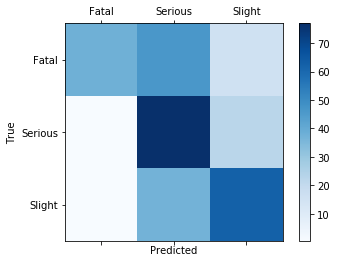

In [12]:
print('Confusion matrix, (%):\n', conf_mat_pct)

labels = ['Fatal', 'Serious', 'Slight']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_pct, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Random Forest Feature ranking:          0                                                1
0   0.1053                                             Time
1   0.0205                             Mode of Travel_4 Car
2   0.0185          Vehicle Manoeuvres_18 Going Ahead Other
3   0.0163                                    Day_Friday   
4   0.0162             Light Conditions (Banded)_1 Daylight
5   0.0162                      Junction Location_8 Jct Mid
6   0.0159                                   Road Class 1_A
7   0.0155                 Light Conditions (Banded)_2 Dark
8   0.0155                                    Day_Thursday 
9   0.0154                 Veh. Leaving C/W_0 Did Not Leave
10  0.0152  Ped. Crossing Decoded_0 No Xing Facility In 50m
11  0.0147                                    Day_Tuesday  
12  0.0147                                    Day_Monday   
13  0.0137                                    Day_Saturday 
14  0.0136                                   Highway_1 TLRN


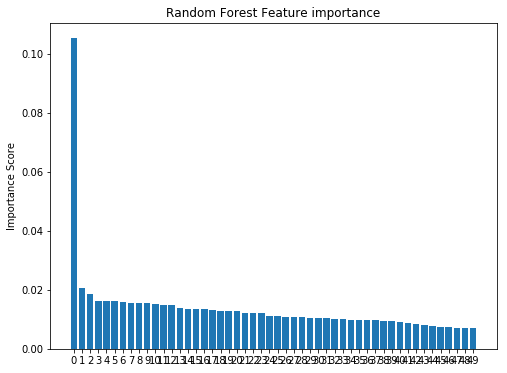

In [13]:
names = X_train_over_under.columns
feat_sort = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
feat_num=50

pl.figure(figsize=(8,6))
pl.title("Random Forest Feature importance")
pl.bar(np.arange(feat_num), pd.DataFrame(feat_sort)[0][:feat_num], align='center')
pl.xticks(np.arange(feat_num))
pl.ylabel('Importance Score')

print("Random Forest Feature ranking:", pd.DataFrame(feat_sort)[:15])

*** Try to hypertune second RF model with Over/Under training set ***

In [16]:
param_grid ={'min_samples_leaf':[1, 5, 10],
             'min_samples_split':[2, 10, 20],
             'max_depth':[None, 5, 10],
             'max_leaf_nodes':[None, 5, 20]} #choose a grid of parameters

rf = RandomForestClassifier(n_jobs=-1)#don't specifcy n_est in the intialization
gr=GridSearchCV(rf,param_grid=param_grid, cv=10)#pass in predictor, and gridded parameters
rs=gr.fit(X_train_over_under,y_train_over_under)#run predictor with each parameter using training data
#pred=rs.predict_proba(X_test)[:,1]
#print (roc_auc_score(np.array(y_test), pred))
print (rs.best_params_) #will output the best parameter
print (rs.best_score_) #will output the best parameter

{'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.778839195253


In [17]:
rf = RandomForestClassifier(n_jobs=-1, random_state=0,n_estimators=100, 
                            max_depth= None, 
                            max_leaf_nodes= None, 
                            min_samples_leaf= 1, 
                            min_samples_split= 2)

rf=rf.fit(X_train_over_under,y_train_over_under)#run predictor with each parameter using training data
pred=rf.predict(X_test)

print ('Accuracy: %.2f' % ((len(y_test[pred == y_test])/len(y_test))*100))

Accuracy: 63.23
